# Homework: Galaxy Image Classification

**Course:** Deep Learning for Computer Vision

**Objective:** Train a deep learning model to classify galaxy images from the Galaxy10 DECals dataset into one of 10 categories.

**Dataset:** Galaxy10 DECals
* **Source:** [Hugging Face Datasets](https://huggingface.co/datasets/matthieulel/galaxy10_decals)
* **Description:** Contains 17,736 color galaxy images (256x256 pixels) divided into 10 classes. Images originate from DESI Legacy Imaging Surveys, with labels from Galaxy Zoo.
* **Classes:**
    * 0: Disturbed Galaxies
    * 1: Merging Galaxies
    * 2: Round Smooth Galaxies
    * 3: In-between Round Smooth Galaxies
    * 4: Cigar Shaped Smooth Galaxies
    * 5: Barred Spiral Galaxies
    * 6: Unbarred Tight Spiral Galaxies
    * 7: Unbarred Loose Spiral Galaxies
    * 8: Edge-on Galaxies without Bulge
    * 9: Edge-on Galaxies with Bulge

**Tasks:**
1.  Load and explore the dataset.
2.  Preprocess the images.
3.  Define and train a model.
4.  Evaluate the model's performance using standard classification metrics on the test set.

Homework is succesfully completed if you get >0.9 Accuracy on the Test set.

# Prerequisites

In [1]:
!pip install datasets scikit-learn matplotlib numpy -q >> None

import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Cell 4: Visualize one example from each class
def show_class_examples(dataset, class_names_map, samples_per_row=5, num_rows=2):
    """Displays one sample image for each class."""
    if not dataset:
        print("Dataset not loaded. Cannot visualize.")
        return

    num_classes_to_show = len(class_names_map)
    if num_classes_to_show > samples_per_row * num_rows:
        print(f"Warning: Not enough space to show all {num_classes_to_show} classes.")
        num_classes_to_show = samples_per_row * num_rows

    fig, axes = plt.subplots(num_rows, samples_per_row, figsize=(15, 6)) # Adjusted figsize
    axes = axes.ravel() # Flatten the axes array

    split_name = 'train' if 'train' in dataset else list(dataset.keys())[0]
    data_split = dataset[split_name]

    images_shown = 0
    processed_labels = set()

    for i in range(len(data_split)):
        if images_shown >= num_classes_to_show:
            break # Stop once we have shown one for each target class

        example = data_split[i]
        label = example['label']

        if label not in processed_labels and label < num_classes_to_show:
            img = example['image']
            ax_idx = label # Use label directly as index into the flattened axes
            axes[ax_idx].imshow(img)
            axes[ax_idx].set_title(f"Class {label}: {class_names_map[label]}", fontsize=9)
            axes[ax_idx].axis('off')
            processed_labels.add(label)
            images_shown += 1

    # Hide any unused subplots
    for i in range(images_shown, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
def evaluate_predictions(predicted_labels, true_labels, class_names_list):
    """
    Calculates and prints classification metrics from predicted labels and true labels.

    Args:
        predicted_labels (list or np.array): The predicted class indices for the test set.
        true_labels (list or np.array): The ground truth class indices for the test set.
        class_names_list (list): A list of strings containing the names of the classes.
    """
    if len(predicted_labels) != len(true_labels):
        print(f"Error: Number of predictions ({len(predicted_labels)}) does not match number of true labels ({len(true_labels)}).")
        return None # Indicate failure

    print(f"Evaluating {len(predicted_labels)} predictions against true labels...")

    # Ensure inputs are numpy arrays for scikit-learn
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Calculate metrics using scikit-learn
    accuracy = accuracy_score(true_labels, predicted_labels)
    # Calculate precision, recall, f1 per class and average (weighted)
    # Use zero_division=0 to handle cases where a class might not be predicted or present in labels
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='weighted', zero_division=0
    )
    # Get per-class metrics as well
    per_class_precision, per_class_recall, per_class_f1, per_class_support = precision_recall_fscore_support(
        true_labels, predicted_labels, average=None, zero_division=0, labels=range(len(class_names_list))
    )

    # Generate Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names_list)))

    # Print Metrics
    print(f"\n--- Evaluation Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("-" * 25)
    print("Per-Class Metrics:")
    print(f"{'Class':<30} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Support':<10}")
    print("-" * 80)
    for i, name in enumerate(class_names_list):
         # Handle cases where support might be 0 for a class in true labels if dataset is small/filtered
         support = per_class_support[i] if i < len(per_class_support) else 0
         prec = per_class_precision[i] if i < len(per_class_precision) else 0
         rec = per_class_recall[i] if i < len(per_class_recall) else 0
         f1s = per_class_f1[i] if i < len(per_class_f1) else 0
         print(f"{f'{i}: {name}':<30} | {prec:<10.4f} | {rec:<10.4f} | {f1s:<10.4f} | {support:<10}")
    print("-" * 80)

    # Plot Confusion Matrix
    print("\nPlotting Confusion Matrix...")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_list)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'confusion_matrix': cm,
        'per_class_metrics': {
            'precision': per_class_precision,
            'recall': per_class_recall,
            'f1': per_class_f1,
            'support': per_class_support
        }
    }
    return metrics

# Data

In [4]:
dataset_name = "matthieulel/galaxy10_decals"
galaxy_dataset = datasets.load_dataset(dataset_name)

# Define class names based on the dataset card
class_names = [
    "Disturbed", "Merging", "Round Smooth", "In-between Round Smooth",
    "Cigar Shaped Smooth", "Barred Spiral", "Unbarred Tight Spiral",
    "Unbarred Loose Spiral", "Edge-on without Bulge", "Edge-on with Bulge"
]

# Create a dictionary for easy lookup
label2name = {i: name for i, name in enumerate(class_names)}
name2label = {name: i for i, name in enumerate(class_names)}

num_classes = len(class_names)
print(f"\nNumber of classes: {num_classes}")
print("Class names:", class_names)

Generating train split:   0%|          | 0/15962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1774 [00:00<?, ? examples/s]


Number of classes: 10
Class names: ['Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Shaped Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']


In [ ]:
show_class_examples(galaxy_dataset, label2name, samples_per_row=5, num_rows=2)

In [6]:
! pip install wavemix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.8 MB/s eta 0:00:00


In [7]:
import torch, wavemix
from wavemix.classification import WaveMix
import torch

# Your training code here

Using device: cuda
Loading Galaxy10 DECals dataset...
Dataset structure: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 15962
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1774
    })
})
Train set size: 13567
Validation set size: 2395
Test set size: 1774


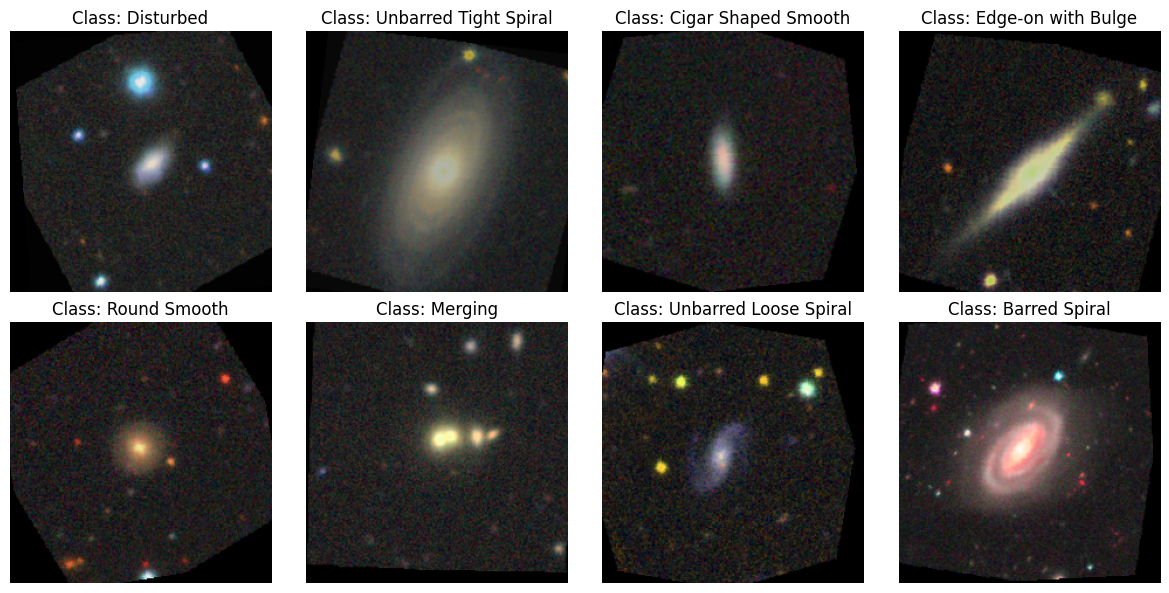

Epoch 1/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 1/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 1.0338, Train Acc: 0.6545 - Val Loss: 0.7268, Val Acc: 0.7424
New best validation accuracy: 0.7424


Epoch 2/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 2/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.6582, Train Acc: 0.7800 - Val Loss: 0.5627, Val Acc: 0.8125
New best validation accuracy: 0.8125


Epoch 3/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 3/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.5790, Train Acc: 0.8069 - Val Loss: 0.5230, Val Acc: 0.8322
New best validation accuracy: 0.8322


Epoch 4/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 4/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.5235, Train Acc: 0.8238 - Val Loss: 0.4967, Val Acc: 0.8355
New best validation accuracy: 0.8355


Epoch 5/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 5/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.5080, Train Acc: 0.8269 - Val Loss: 0.4754, Val Acc: 0.8392
New best validation accuracy: 0.8392


Epoch 6/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 6/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.4690, Train Acc: 0.8443 - Val Loss: 0.4910, Val Acc: 0.8401
New best validation accuracy: 0.8401


Epoch 7/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 7/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.4540, Train Acc: 0.8464 - Val Loss: 0.4535, Val Acc: 0.8476
New best validation accuracy: 0.8476


Epoch 8/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 8/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.4438, Train Acc: 0.8454 - Val Loss: 0.4294, Val Acc: 0.8614
New best validation accuracy: 0.8614


Epoch 9/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 9/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.4197, Train Acc: 0.8575 - Val Loss: 0.4331, Val Acc: 0.8576
Validation accuracy did not improve. Patience: 1/5


Epoch 10/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 10/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.4068, Train Acc: 0.8591 - Val Loss: 0.4483, Val Acc: 0.8501
Validation accuracy did not improve. Patience: 2/5


Epoch 11/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 11/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.3935, Train Acc: 0.8637 - Val Loss: 0.4440, Val Acc: 0.8589
Validation accuracy did not improve. Patience: 3/5


Epoch 12/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 12/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.3757, Train Acc: 0.8706 - Val Loss: 0.3992, Val Acc: 0.8706
New best validation accuracy: 0.8706


Epoch 13/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 13/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.3699, Train Acc: 0.8686 - Val Loss: 0.4648, Val Acc: 0.8505
Validation accuracy did not improve. Patience: 1/5


Epoch 14/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 14/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.3454, Train Acc: 0.8789 - Val Loss: 0.4632, Val Acc: 0.8434
Validation accuracy did not improve. Patience: 2/5


Epoch 15/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 15/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.3410, Train Acc: 0.8788 - Val Loss: 0.4546, Val Acc: 0.8614
Validation accuracy did not improve. Patience: 3/5


Epoch 16/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 16/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 00016: reducing learning rate of group 0 to 1.0000e-05.
Epoch 16/30 - Train Loss: 0.3416, Train Acc: 0.8830 - Val Loss: 0.4243, Val Acc: 0.8593
Validation accuracy did not improve. Patience: 4/5


Epoch 17/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 17/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.2665, Train Acc: 0.9085 - Val Loss: 0.3956, Val Acc: 0.8747
New best validation accuracy: 0.8747


Epoch 18/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 18/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.2428, Train Acc: 0.9135 - Val Loss: 0.3986, Val Acc: 0.8793
New best validation accuracy: 0.8793


Epoch 19/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 19/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.2374, Train Acc: 0.9165 - Val Loss: 0.4040, Val Acc: 0.8739
Validation accuracy did not improve. Patience: 1/5


Epoch 20/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 20/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.2308, Train Acc: 0.9180 - Val Loss: 0.3999, Val Acc: 0.8764
Validation accuracy did not improve. Patience: 2/5


Epoch 21/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 21/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 00021: reducing learning rate of group 0 to 1.0000e-06.
Epoch 21/30 - Train Loss: 0.2180, Train Acc: 0.9244 - Val Loss: 0.4050, Val Acc: 0.8789
Validation accuracy did not improve. Patience: 3/5


Epoch 22/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 22/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.2177, Train Acc: 0.9216 - Val Loss: 0.4008, Val Acc: 0.8793
Validation accuracy did not improve. Patience: 4/5


Epoch 23/30 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 23/30 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.2100, Train Acc: 0.9248 - Val Loss: 0.4000, Val Acc: 0.8789
Validation accuracy did not improve. Patience: 5/5
Early stopping triggered after 23 epochs


Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]


Test Accuracy: 0.8766

Classification Report:
                         precision    recall  f1-score   support

              Disturbed       0.71      0.56      0.63       109
                Merging       0.93      0.92      0.93       185
           Round Smooth       0.90      0.98      0.94       250
In-between Round Smooth       0.91      0.94      0.92       198
    Cigar Shaped Smooth       0.80      0.86      0.83        28
          Barred Spiral       0.90      0.88      0.89       217
  Unbarred Tight Spiral       0.80      0.79      0.80       179
  Unbarred Loose Spiral       0.81      0.80      0.80       273
  Edge-on without Bulge       0.95      0.93      0.94       157
     Edge-on with Bulge       0.94      0.96      0.95       178

               accuracy                           0.88      1774
              macro avg       0.86      0.86      0.86      1774
           weighted avg       0.87      0.88      0.87      1774



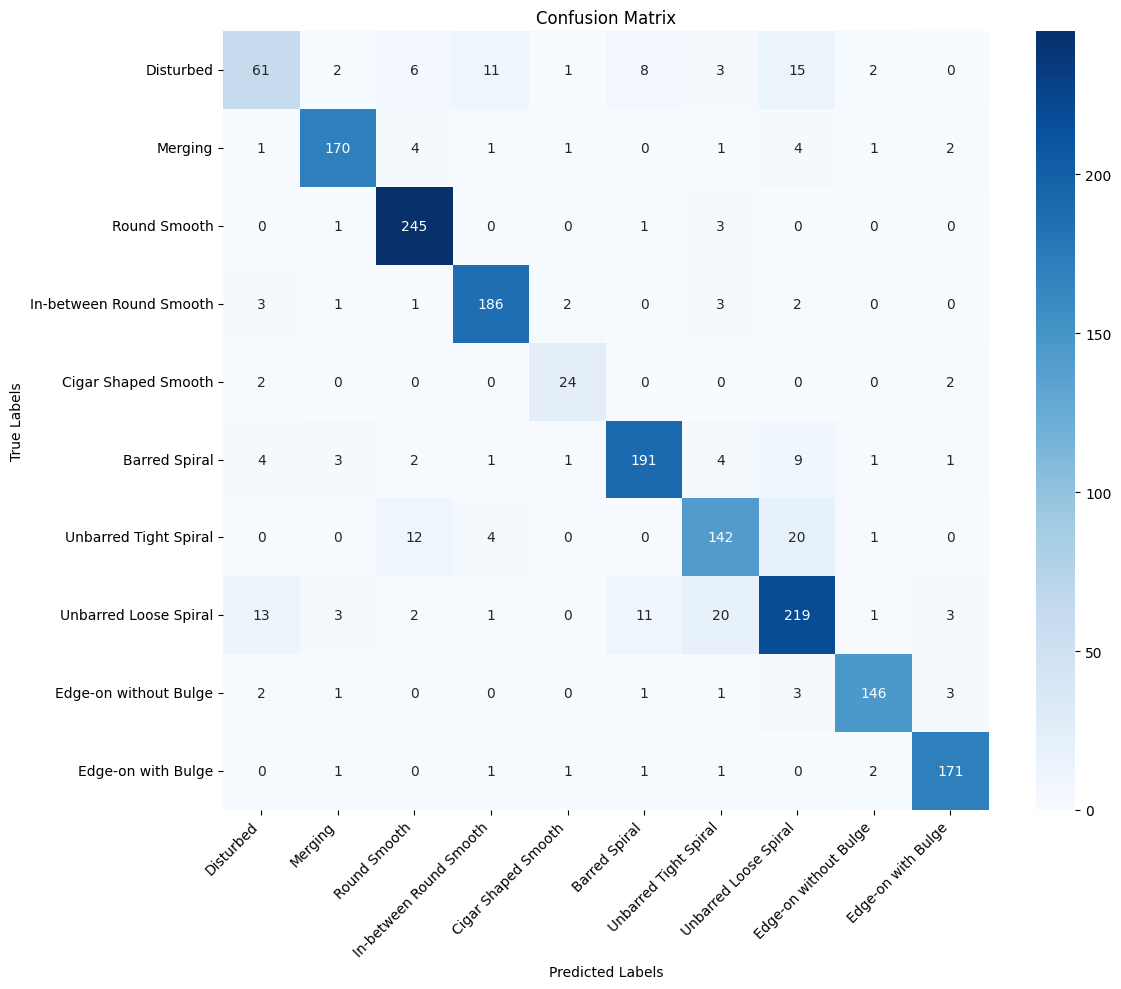

Error visualizing sample 999: Wrong key type: '999' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.
Error visualizing sample 596: Wrong key type: '596' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.
Error visualizing sample 1132: Wrong key type: '1132' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.
Error visualizing sample 270: Wrong key type: '270' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.
Error visualizing sample 414: Wrong key type: '414' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.


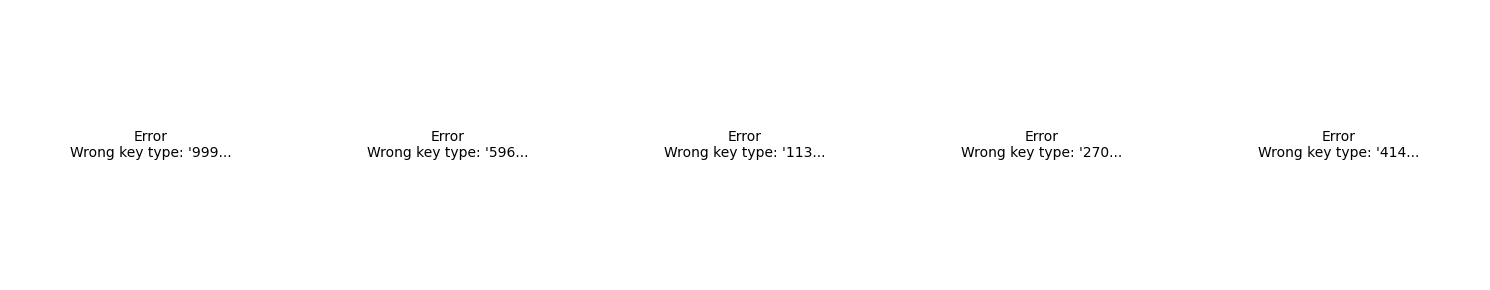

Model saved to galaxy_classifier.pth

⚠️ The model didn't achieve >0.9 accuracy on the test set. Try adjusting hyperparameters or the model architecture.


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
import torchvision.transforms.functional as TF
from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import random
import wandb
from tqdm.notebook import tqdm
import seaborn as sns

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Configuration
CONFIG = {
    "model_name": "resnet50",  # Options: resnet50, efficientnet_b0, densenet121
    "pretrained": True,
    "image_size": 224,
    "batch_size": 32,
    "num_workers": 2,  # Reduced from 4 to avoid warning
    "learning_rate": 0.0001,
    "weight_decay": 1e-5,
    "epochs": 30,  # Increased from 15 to give more training time
    "early_stopping_patience": 5,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "use_wandb": False  # Set to False by default as it requires setup
}

print(f"Using device: {CONFIG['device']}")

# Define class names
class_names = [
    "Disturbed", "Merging", "Round Smooth", "In-between Round Smooth",
    "Cigar Shaped Smooth", "Barred Spiral", "Unbarred Tight Spiral",
    "Unbarred Loose Spiral", "Edge-on without Bulge", "Edge-on with Bulge"
]

# Create a dictionary for easy lookup
label2name = {i: name for i, name in enumerate(class_names)}
name2label = {name: i for i, name in enumerate(class_names)}
num_classes = len(class_names)

# Custom Dataset Class
class GalaxyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Handle the case where dataset is a Subset from random_split
        if hasattr(self.dataset, 'dataset'):
            # This is a subset
            actual_idx = self.dataset.indices[idx]
            sample = self.dataset.dataset[actual_idx]
        else:
            # Direct dataset access
            sample = self.dataset[idx]

        image = sample['image']
        label = sample['label']

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

# Data augmentation and preprocessing
def get_transforms(train=True):
    if train:
        return transforms.Compose([
            # No ToPILImage needed - images are already PIL images
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30),
            transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
            # Добавленные две аугментации
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            # No ToPILImage needed - images are already PIL images
            transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


# Load and prepare dataset
def prepare_data():
    print("Loading Galaxy10 DECals dataset...")
    dataset = load_dataset("matthieulel/galaxy10_decals")

    # Check dataset structure
    print(f"Dataset structure: {dataset}")

    # Get the training dataset
    full_train_dataset = dataset["train"]
    test_dataset = dataset["test"]

    # Split train into train and validation sets (85%, 15%)
    total_train_size = len(full_train_dataset)
    train_size = int(0.85 * total_train_size)
    val_size = total_train_size - train_size

    # Create a generator for reproducibility
    generator = torch.Generator().manual_seed(SEED)

    # Split dataset
    train_dataset, val_dataset = random_split(
        full_train_dataset, [train_size, val_size], generator=generator
    )

    print(f"Train set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    # Create datasets with transforms
    train_data = GalaxyDataset(train_dataset, transform=get_transforms(train=True))
    val_data = GalaxyDataset(val_dataset, transform=get_transforms(train=False))
    test_data = GalaxyDataset(test_dataset, transform=get_transforms(train=False))

    # Create data loaders
    train_loader = DataLoader(
        train_data,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=CONFIG['num_workers'],
        pin_memory=True if CONFIG['device'] == 'cuda' else False
    )

    val_loader = DataLoader(
        val_data,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True if CONFIG['device'] == 'cuda' else False
    )

    test_loader = DataLoader(
        test_data,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True if CONFIG['device'] == 'cuda' else False
    )

    return train_loader, val_loader, test_loader, train_data, val_data, test_data

# Define the model
def get_model(model_name='resnet50', pretrained=True):
    if model_name == 'resnet50':
        model = models.resnet50(weights='IMAGENET1K_V2' if pretrained else None)
        # Replace final fully connected layer
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights='IMAGENET1K_V1' if pretrained else None)
        # Replace final classifier
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'densenet121':
        model = models.densenet121(weights='IMAGENET1K_V1' if pretrained else None)
        # Replace final classifier
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)

    else:
        raise ValueError(f"Model {model_name} not supported")

    return model

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=10):
    # Initialize WandB if enabled
    if CONFIG['use_wandb']:
        wandb.init(
            project="galaxy-classification",
            config=CONFIG
        )
        wandb.watch(model)

    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # Update progress bar
            train_loop.set_postfix(loss=loss.item(), acc=train_correct/train_total)

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
            for inputs, labels in val_loop:
                inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # Update progress bar
                val_loop.set_postfix(loss=loss.item(), acc=val_correct/val_total)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total

        # Update learning rate scheduler if provided
        if scheduler:
            scheduler.step(val_loss)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Log to WandB if enabled
        if CONFIG['use_wandb']:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "learning_rate": optimizer.param_groups[0]['lr']
            })

        # Check if this is the best model so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"New best validation accuracy: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            print(f"Validation accuracy did not improve. Patience: {patience_counter}/{CONFIG['early_stopping_patience']}")

        # Early stopping
        if patience_counter >= CONFIG['early_stopping_patience']:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Load the best model state
    model.load_state_dict(best_model_state)

    # Finish WandB run if enabled
    if CONFIG['use_wandb']:
        wandb.finish()

    return model

# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    return accuracy, all_preds, all_labels

# Visualize predictions on random samples
def visualize_predictions(model, dataset, num_samples=5):
    # Get random samples from the dataset
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    model.eval()

    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))

    for i, idx in enumerate(indices):
        try:
            image, label = dataset[idx]

            # Ensure we have a tensor
            if not isinstance(image, torch.Tensor):
                # Apply the transform manually if needed
                transform = get_transforms(train=False)
                image = transform(image)

            image_for_display = image.clone().detach()

            # Unnormalize the image for display
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image_for_display = image_for_display * std + mean
            image_for_display = image_for_display.permute(1, 2, 0).numpy()
            image_for_display = np.clip(image_for_display, 0, 1)

            # Get prediction
            with torch.no_grad():
                input_tensor = image.unsqueeze(0).to(CONFIG['device'])
                output = model(input_tensor)
                _, pred = torch.max(output, 1)
                pred = pred.item()

            # Display the image with true and predicted labels
            axs[i].imshow(image_for_display)
            color = 'green' if pred == label else 'red'
            axs[i].set_title(f"True: {label2name[label]}\nPred: {label2name[pred]}", color=color, fontsize=8)
        except Exception as e:
            print(f"Error visualizing sample {idx}: {e}")
            axs[i].text(0.5, 0.5, f"Error\n{str(e)[:20]}...",
                       horizontalalignment='center', verticalalignment='center')

        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.show()

# Save model
def save_model(model, path='galaxy_classifier.pth'):
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': CONFIG
    }, path)
    print(f"Model saved to {path}")

# Main function
def main():
    # Prepare data
    train_loader, val_loader, test_loader, train_data, val_data, test_data = prepare_data()

    # Visualize a few samples from the dataset
    images, labels = next(iter(train_loader))
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))
    axs = axs.flatten()

    for i in range(min(8, len(images))):
        # Unnormalize the image for display
        img = images[i].clone().detach()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        axs[i].imshow(img)
        axs[i].set_title(f"Class: {label2name[labels[i].item()]}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig('sample_images.png')
    plt.show()

    # Initialize model
    model = get_model(model_name=CONFIG['model_name'], pretrained=CONFIG['pretrained'])
    model = model.to(CONFIG['device'])

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])

    # Define scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, verbose=True
    )

    # Train the model
    trained_model = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        epochs=CONFIG['epochs']
    )

    # Evaluate on test set
    test_accuracy, all_preds, all_labels = evaluate_model(trained_model, test_loader)

    # Visualize some predictions
    visualize_predictions(trained_model, test_data)

    # Save the model
    save_model(trained_model)

    if test_accuracy > 0.9:
        print("\n🎉 SUCCESS! You've achieved >0.9 accuracy on the test set as required.")
    else:
        print("\n⚠️ The model didn't achieve >0.9 accuracy on the test set. Try adjusting hyperparameters or the model architecture.")

if __name__ == "__main__":
    main()

Using device: cuda
Loading Galaxy10 DECals dataset...
Dataset structure: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 15962
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1774
    })
})
Train set size: 13567
Validation set size: 2395
Test set size: 1774


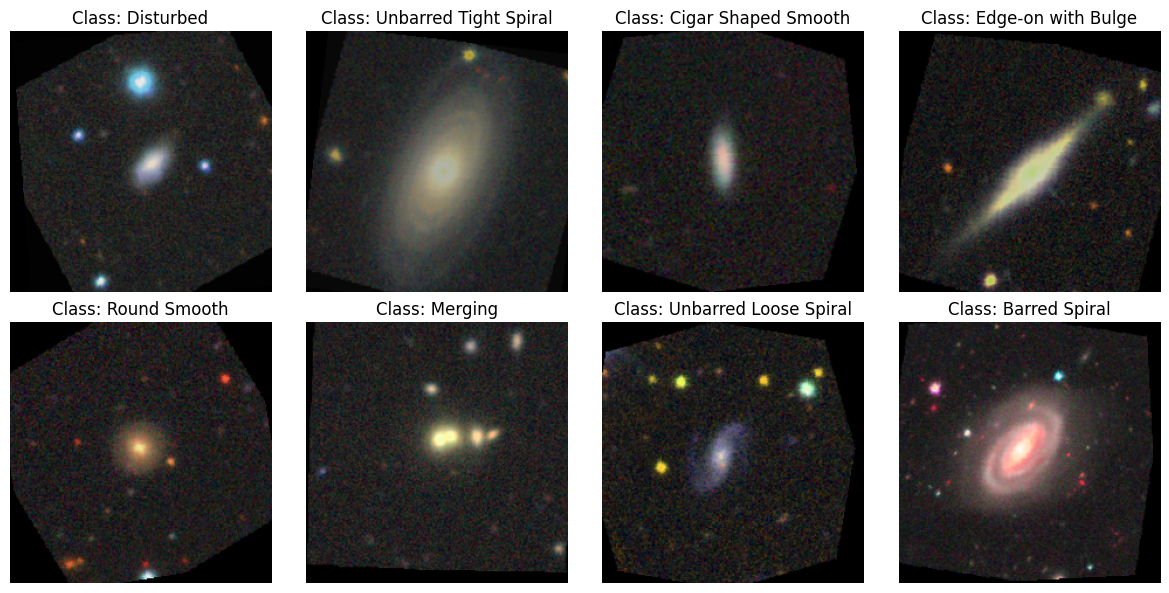

Epoch 1/100 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 1.3862, Train Acc: 0.5070 - Val Loss: 1.1718, Val Acc: 0.6058
New best validation accuracy: 0.6058


Epoch 2/100 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/100 - Train Loss: 1.0070, Train Acc: 0.6489 - Val Loss: 0.9266, Val Acc: 0.6731
New best validation accuracy: 0.6731


Epoch 3/100 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/100 - Train Loss: 0.9281, Train Acc: 0.6795 - Val Loss: 0.8849, Val Acc: 0.6927
New best validation accuracy: 0.6927


Epoch 4/100 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 4/100 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/100 - Train Loss: 0.8936, Train Acc: 0.6881 - Val Loss: 0.8486, Val Acc: 0.6998
New best validation accuracy: 0.6998


Epoch 5/100 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 5/100 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5/100 - Train Loss: 0.8381, Train Acc: 0.7058 - Val Loss: 0.8090, Val Acc: 0.7186
New best validation accuracy: 0.7186


Epoch 6/100 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 6/100 - Train Loss: 0.8221, Train Acc: 0.7171 - Val Loss: 0.7958, Val Acc: 0.7257
New best validation accuracy: 0.7257


Epoch 7/100 [Train]:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
import torchvision.transforms.functional as TF
from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import random
import wandb
from tqdm.notebook import tqdm
import seaborn as sns

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Configuration
CONFIG = {
    "model_name": "resnet50",  # Options: resnet50, efficientnet_b0, densenet121
    "pretrained": True,
    "image_size": 224,
    "batch_size": 32,
    "num_workers": 2,  # Reduced from 4 to avoid warning
    "learning_rate": 0.0001,
    "weight_decay": 1e-5,
    "epochs": 100,  # Increased from 15 to give more training time
    "early_stopping_patience": 8,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "use_wandb": False  # Set to False by default as it requires setup
}

print(f"Using device: {CONFIG['device']}")

# Define class names
class_names = [
    "Disturbed", "Merging", "Round Smooth", "In-between Round Smooth",
    "Cigar Shaped Smooth", "Barred Spiral", "Unbarred Tight Spiral",
    "Unbarred Loose Spiral", "Edge-on without Bulge", "Edge-on with Bulge"
]

# Create a dictionary for easy lookup
label2name = {i: name for i, name in enumerate(class_names)}
name2label = {name: i for i, name in enumerate(class_names)}
num_classes = len(class_names)

# Custom Dataset Class
class GalaxyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Handle the case where dataset is a Subset from random_split
        if hasattr(self.dataset, 'dataset'):
            # This is a subset
            actual_idx = self.dataset.indices[idx]
            sample = self.dataset.dataset[actual_idx]
        else:
            # Direct dataset access
            sample = self.dataset[idx]

        image = sample['image']
        label = sample['label']

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

# Data augmentation and preprocessing
def get_transforms(train=True):
    if train:
        return transforms.Compose([
            # No ToPILImage needed - images are already PIL images
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30),
            transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
            # Добавленные две аугментации
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            # No ToPILImage needed - images are already PIL images
            transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


# Load and prepare dataset
def prepare_data():
    print("Loading Galaxy10 DECals dataset...")
    dataset = load_dataset("matthieulel/galaxy10_decals")

    # Check dataset structure
    print(f"Dataset structure: {dataset}")

    # Get the training dataset
    full_train_dataset = dataset["train"]
    test_dataset = dataset["test"]

    # Split train into train and validation sets (85%, 15%)
    total_train_size = len(full_train_dataset)
    train_size = int(0.85 * total_train_size)
    val_size = total_train_size - train_size

    # Create a generator for reproducibility
    generator = torch.Generator().manual_seed(SEED)

    # Split dataset
    train_dataset, val_dataset = random_split(
        full_train_dataset, [train_size, val_size], generator=generator
    )

    print(f"Train set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    # Create datasets with transforms
    train_data = GalaxyDataset(train_dataset, transform=get_transforms(train=True))
    val_data = GalaxyDataset(val_dataset, transform=get_transforms(train=False))
    test_data = GalaxyDataset(test_dataset, transform=get_transforms(train=False))

    # Create data loaders
    train_loader = DataLoader(
        train_data,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=CONFIG['num_workers'],
        pin_memory=True if CONFIG['device'] == 'cuda' else False
    )

    val_loader = DataLoader(
        val_data,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True if CONFIG['device'] == 'cuda' else False
    )

    test_loader = DataLoader(
        test_data,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True if CONFIG['device'] == 'cuda' else False
    )

    return train_loader, val_loader, test_loader, train_data, val_data, test_data

# Define the model
# def get_model(model_name='resnet50', pretrained=True):
#     if model_name == 'resnet50':
#         model = models.resnet50(weights='IMAGENET1K_V2' if pretrained else None)
#         # Replace final fully connected layer
#         num_ftrs = model.fc.in_features
#         model.fc = nn.Linear(num_ftrs, num_classes)

#     elif model_name == 'efficientnet_b0':
#         model = models.efficientnet_b0(weights='IMAGENET1K_V1' if pretrained else None)
#         # Replace final classifier
#         num_ftrs = model.classifier[1].in_features
#         model.classifier[1] = nn.Linear(num_ftrs, num_classes)

#     elif model_name == 'densenet121':
#         model = models.densenet121(weights='IMAGENET1K_V1' if pretrained else None)
#         # Replace final classifier
#         num_ftrs = model.classifier.in_features
#         model.classifier = nn.Linear(num_ftrs, num_classes)

#     else:
#         raise ValueError(f"Model {model_name} not supported")

#     return model
def get_model(model_name='resnet50', pretrained=True):
    if model_name == 'resnet50':
        model = models.resnet50(weights='IMAGENET1K_V2' if pretrained else None)
        
        # Freeze initial layers except layer4 and fc
        for name, param in model.named_parameters():
            if 'layer4' not in name and 'fc' not in name:
                param.requires_grad = False
                
        # Modify the fully connected layers
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        return model  # Added return statement

    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights='IMAGENET1K_V1' if pretrained else None)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        return model

    elif model_name == 'densenet121':
        model = models.densenet121(weights='IMAGENET1K_V1' if pretrained else None)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        return model

    else:
        raise ValueError(f"Model {model_name} not supported")

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=10):
    # Initialize WandB if enabled
    if CONFIG['use_wandb']:
        wandb.init(
            project="galaxy-classification",
            config=CONFIG
        )
        wandb.watch(model)

    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # Update progress bar
            train_loop.set_postfix(loss=loss.item(), acc=train_correct/train_total)

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
            for inputs, labels in val_loop:
                inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # Update progress bar
                val_loop.set_postfix(loss=loss.item(), acc=val_correct/val_total)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total

        # Update learning rate scheduler if provided
        if scheduler:
            scheduler.step(val_loss)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Log to WandB if enabled
        if CONFIG['use_wandb']:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "learning_rate": optimizer.param_groups[0]['lr']
            })

        # Check if this is the best model so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"New best validation accuracy: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            print(f"Validation accuracy did not improve. Patience: {patience_counter}/{CONFIG['early_stopping_patience']}")

        # Early stopping
        if patience_counter >= CONFIG['early_stopping_patience']:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Load the best model state
    model.load_state_dict(best_model_state)

    # Finish WandB run if enabled
    if CONFIG['use_wandb']:
        wandb.finish()

    return model

# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    return accuracy, all_preds, all_labels

# Visualize predictions on random samples
def visualize_predictions(model, dataset, num_samples=5):
    # Get random samples from the dataset
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    model.eval()

    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))

    for i, idx in enumerate(indices):
        try:
            image, label = dataset[idx]

            # Ensure we have a tensor
            if not isinstance(image, torch.Tensor):
                # Apply the transform manually if needed
                transform = get_transforms(train=False)
                image = transform(image)

            image_for_display = image.clone().detach()

            # Unnormalize the image for display
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image_for_display = image_for_display * std + mean
            image_for_display = image_for_display.permute(1, 2, 0).numpy()
            image_for_display = np.clip(image_for_display, 0, 1)

            # Get prediction
            with torch.no_grad():
                input_tensor = image.unsqueeze(0).to(CONFIG['device'])
                output = model(input_tensor)
                _, pred = torch.max(output, 1)
                pred = pred.item()

            # Display the image with true and predicted labels
            axs[i].imshow(image_for_display)
            color = 'green' if pred == label else 'red'
            axs[i].set_title(f"True: {label2name[label]}\nPred: {label2name[pred]}", color=color, fontsize=8)
        except Exception as e:
            print(f"Error visualizing sample {idx}: {e}")
            axs[i].text(0.5, 0.5, f"Error\n{str(e)[:20]}...",
                       horizontalalignment='center', verticalalignment='center')

        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.show()

# Save model
def save_model(model, path='galaxy_classifier.pth'):
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': CONFIG
    }, path)
    print(f"Model saved to {path}")

# Main function
def main():
    # Prepare data
    train_loader, val_loader, test_loader, train_data, val_data, test_data = prepare_data()

    # Visualize a few samples from the dataset
    images, labels = next(iter(train_loader))
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))
    axs = axs.flatten()

    for i in range(min(8, len(images))):
        # Unnormalize the image for display
        img = images[i].clone().detach()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        axs[i].imshow(img)
        axs[i].set_title(f"Class: {label2name[labels[i].item()]}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig('sample_images.png')
    plt.show()

    # Initialize model
    model = get_model(model_name=CONFIG['model_name'], pretrained=CONFIG['pretrained'])
    model = model.to(CONFIG['device'])

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])

    # Define scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, verbose=True
    )

    # Train the model
    trained_model = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        epochs=CONFIG['epochs']
    )

    # Evaluate on test set
    test_accuracy, all_preds, all_labels = evaluate_model(trained_model, test_loader)

    # Visualize some predictions
    visualize_predictions(trained_model, test_data)

    # Save the model
    save_model(trained_model)

    if test_accuracy > 0.9:
        print("\n🎉 SUCCESS! You've achieved >0.9 accuracy on the test set as required.")
    else:
        print("\n⚠️ The model didn't achieve >0.9 accuracy on the test set. Try adjusting hyperparameters or the model architecture.")

if __name__ == "__main__":
    main()

# Evaluation